In [ ]:
import os
import torch
os.environ["TORCH_VERSION"] = torch.__version__

!pip install torch-scatter torch-cluster -f https://pytorch-geometric.com/whl/torch-$TORCH_VERSION.html
!pip install torchdrug
!pip install wandb

In [3]:
import torch
from torchdrug import data, datasets

Load the ClinTox dataset and split it into training (80%), validation (10%), and test (10%) sets

ClinTox contains 1,484 molecules labeled with FDA approvment status and toxity status in clinical trials.

In [ ]:
# @title Preparing the Dataset
dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)


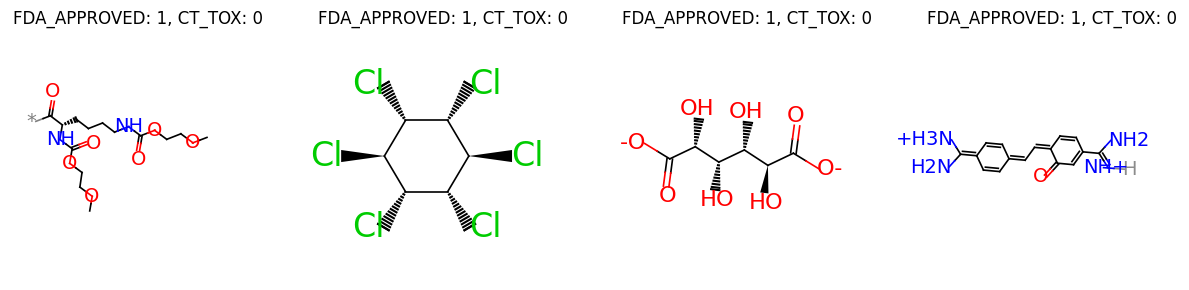

In [32]:
%matplotlib inline

graphs = []
labels = []
for i in range(4):
    sample = dataset[i]
    graphs.append(sample.pop("graph"))
    label = ["%s: %d" % (k, v) for k, v in sample.items()]
    label = ", ".join(label)
    labels.append(label)
graph = data.Molecule.pack(graphs)
graph.visualize(labels, num_row=1)

We are using a GIN (Graph Isomorphism Network) with 4 hidden laysers
The two prediction tasks (FDA approval and toxicity) will be optimized through training

In [8]:
# @title Defining the Model
from torchdrug import core, models, tasks, utils

model = models.GIN(
    input_dim=dataset.node_feature_dim,
    hidden_dims=[256, 256, 256, 256],
    short_cut=True,
    batch_norm=True,
    concat_hidden=True
)

task = tasks.PropertyPrediction(
    model,
    task=dataset.tasks,
    criterion="bce",
    metric=("auprc", "auroc")
)

In [ ]:
# @title Training the model
optimizer = torch.optim.Adam(task.parameters(), lr=1e-3)
solver = core.Engine(task, train_set, valid_set, test_set, optimizer, gpus=[0], batch_size=1024)
solver.train(num_epoch=100)
solver.evaluate("valid")

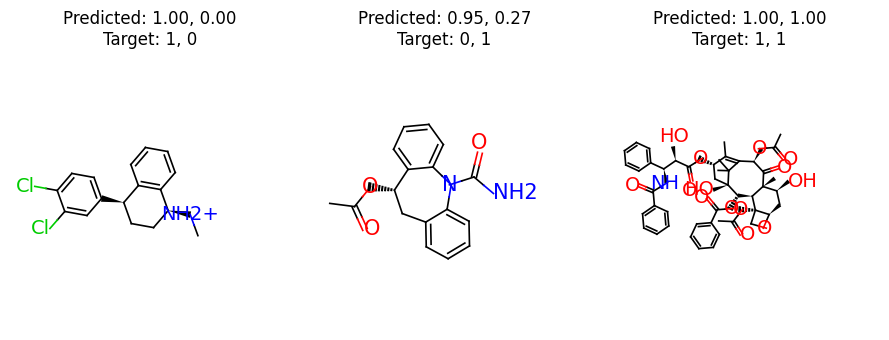

In [36]:
# @title Results
%matplotlib inline

from torch.nn import functional as F

samples = []
categories = set()
for sample in valid_set:
    category = tuple([v for k, v in sample.items() if k != "graph"])
    if category not in categories:
        categories.add(category)
        samples.append(sample)

samples = data.graph_collate(samples)
samples = utils.cuda(samples)
preds = F.sigmoid(task.predict(samples))
targets = task.target(samples)

titles = []
for pred, target in zip(preds, targets):
    pred_str = ", ".join(["%.2f" % p for p in pred])
    target_str = ", ".join(["%d" % t for t in target])
    titles.append(f"Predicted: {pred_str}\nTarget: {target_str}")

graph = samples["graph"]

graph.visualize(titles, save_file="png", figure_size=(3, 3.5), num_row=1)
